# Modelling Afterpay's customer growth
> How can we model the growth in Afterpay's customer base?

- toc: true 
- badges: true
- comments: true
- categories: [Bayesian,PyMC3,Finance,Monte Carlo Simulation,Afterpay]
    
- image: images/2020-08-13-Modelling-Afterpays-Customer-Growth/header.png

## The Context


> Important:  Obviously I need a disclaimer. If you use anything I say as the basis for any decision, financial or otherwise, you are an idiot.


## The Model

First off, let's load in a bunch of libraries.

In [1]:
%matplotlib inline
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np

from io import StringIO
import pandas as pd

import math

plt.rcParams["figure.figsize"] = (10,10)
from warnings import filterwarnings
filterwarnings('ignore')


While reading through Afterpay's releases to the markets, I came across this chart, which appears on page 3 of [this](https://www.afterpaytouch.com/images/APT_ASX-Announcement_Q2-FY18_16-Jan-Final-2.pdf) release.


![Image of Afterpay custmer growth](../images/2020-08-13-Modelling-Afterpays-Customer-Growth/CustomerGrowth.png)


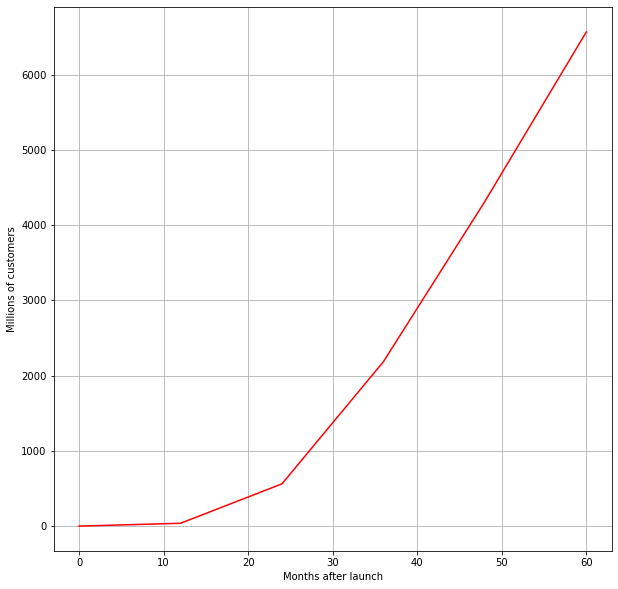

In [2]:
#Underlying sales
csv_data = StringIO('''anz_underlying_sales_value,date,month_count
0,FY15,0
37.3,FY16,12
561.2,FY17,24
2184.6,FY18,36
4314.1,FY19,48
6566.9,FY20,60''')

df = pd.read_csv(csv_data, sep=",")
plt.plot(df.month_count,df.anz_underlying_sales_value,color='r')
plt.ylabel('Millions of customers')
plt.xlabel('Months after launch')
plt.grid()
plt.show()

[  2.17012649 -17.61639881 -58.725     ]


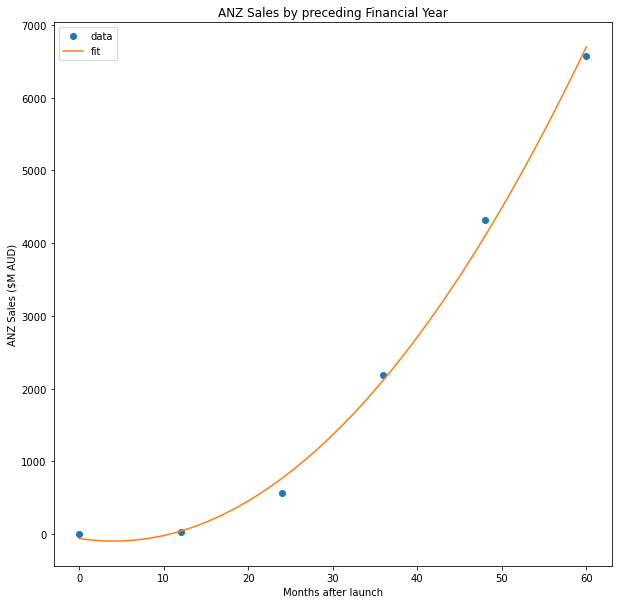

In [3]:
from scipy.optimize import curve_fit

def quadratic(x, a, b, c):
     y = a * x**2 + b * x + c
     return y

xdata = df.month_count.values
ydata = df.anz_underlying_sales_value.values

popt, pcov = curve_fit(quadratic, xdata, ydata)

print(popt)
x = np.linspace(0,60, 61)
y = quadratic(x, *popt)

plt.plot(xdata, ydata, 'o', label='data')
plt.plot(x,y, label='fit')

#section = np.linspace(20,40, 100)
#plt.fill_between(section,sigmoid(section, *popt))

plt.title('ANZ Sales by preceding Financial Year')
plt.xlabel('Months after launch')
plt.ylabel('ANZ Sales ($M AUD)')
plt.legend(loc='best')
plt.show()

Ok, let's pause for a moment, and actually think about what this curve represents.

It's the sum, or integral of the total sales for the preceding 1 year period. 

Now, let's find the derivative of this function, which will give us the instantanious rate change of total sales, at any given point in time.

In [6]:


a,b,c,d,x,y = sym.symbols('a b c d x y')
sym.init_printing(use_unicode=True)

expr = sym.diff(a*x**2 + b*x + c + d,x)
print(expr)

f = sym.lambdify([a,b,x], expr, "numpy")


2*a*x + b


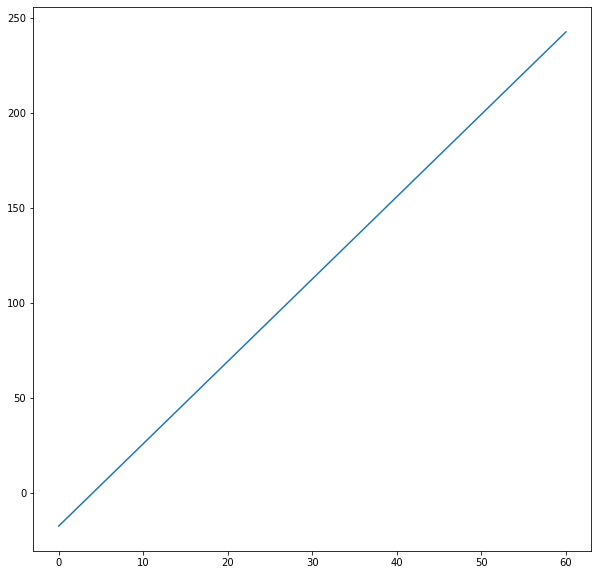

In [7]:
x = np.linspace(0,60, 61)
y = f(2.17012649,-17.61639881,x)
plt.plot(x,y)
plt.show()

In [9]:
#this is our integral
expr = sym.simplify((a*x**3 + b*x**2 + c*x + d) - (a*(x-12)**3 + b*(x-12)**2 + c*(x-12) + d))  

In [10]:
expr

In [11]:
expr = sym.expand(a*(x-12)**2 + b*(x-12) + c)

In [12]:
expr

In [21]:
sym.collect(expr,x).coeff(x, 2)

In [14]:
fitted = x**2 * 2.17012649 + x*-17.61639881 -58.725
fitted


In [26]:
print(sym.collect(expr,x).coeff(x, 2))
print(sym.collect(fitted,x).coeff(x, 2))


equations = []

for i in [2,1,0]:
    eq = sym.collect(expr,x).coeff(x, i)
    coeff = sym.collect(fitted,x).coeff(x, i)
    equations.append(sym.Eq(eq,coeff))

print(equations)

result = sym.solve(equations,(a,b,c))

a
2.17012649000000
[Eq(a, 2.17012649), Eq(-24*a + b, -17.61639881), Eq(144*a - 12*b + c, -58.725)]


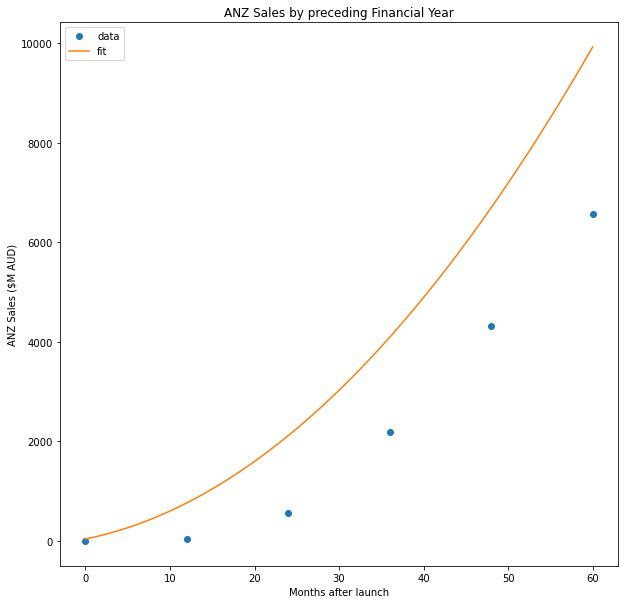

In [38]:
#result

result[a]

x = np.linspace(0,60, 61)
y = quadratic(x,result[a],result[b],result[c])

plt.plot(xdata, ydata, 'o', label='data')


plt.plot(x,y, label='fit')

#section = np.linspace(20,40, 100)
#plt.fill_between(section,sigmoid(section, *popt))

plt.title('ANZ Sales by preceding Financial Year')
plt.xlabel('Months after launch')
plt.ylabel('ANZ Sales ($M AUD)')
plt.legend(loc='best')
plt.show()

